In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pickle as pkl
from argparse import ArgumentParser
from copy import deepcopy
from os.path import join as oj
import numpy as np
import torch
from torch import nn
import torch.utils.data
from torch import optim
import pickle
from torch.utils.data import DataLoader, TensorDataset
sys.path.insert(0, "../code_fga")
sys.path.insert(0, "..")
import data_fns
import utils
import pandas as pd
import models
# import cmcrameri.cm as cmc
import torchvision
from matplotlib import pyplot as plt
import matplotlib as mpl
# mpl.rc('image', cmap='cmc.batlow')
cuda = torch.cuda.is_available()

if not cuda:
    sys.exit()
device = torch.device("cuda")
import data
from sklearn import metrics
import configparser
config = configparser.ConfigParser()
config.read("../config.ini")

['../config.ini']

In [3]:
data_path = config["PATHS"]["data_path"]
model_path = config["PATHS"]["model_path"]

fig_path = config["PATHS"]["fig_path"]
PATH_IR_INDEX = oj(data_path,'ir_spectra_index.pkl')
PATH_IR_DATA = oj(data_path,'ir_spectra_data.pkl')


with open(PATH_IR_DATA, 'rb') as pickle_file:
    irdata = pickle.load(pickle_file)
    
with open(PATH_IR_INDEX, 'rb') as pickle_file:
    irindex = pickle.load(pickle_file)
filters = (('state', 'gas'), ('yunits', 'ABSORBANCE'), ('xunits', '1/CM'))
x, y = utils.fixed_domain_filter(irdata, irindex, filters)

x /= x.max(axis=1)[:, None]  # (batch_size, features)
x = x[:, None]
train_idxs, val_idxs, test_idxs = data_fns.get_split(len(x), seed=42)


In [4]:
all_idxs = np.arange(len(x))

In [5]:
fnames = sorted([oj(model_path, fname) for fname in os.listdir(model_path) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results_all = pd.concat(results_list, axis=1).T.infer_objects()


In [6]:

results_all = results_all[results_all.exp_name == "FinalModels"]

In [7]:
used_idxs= test_idxs


In [8]:
model_idx =  results_all.val_auc.argmax()

model = models.FGANet(num_input= x.shape[2],
                      num_in_channels=1, 
                      num_output = y.shape[1], 
      
                      conv_channels = results_all.iloc[model_idx].num_conv,
                      stride = 1).to(device)

model.load_state_dict(torch.load(oj(model_path,results_all.iloc[model_idx].filename+".pt")))
model = model.to(device)
model.eval();

In [9]:
pred_y = model.forward(torch.Tensor(x[used_idxs]).cuda()).detach().cpu().numpy()
true_y = y[used_idxs]

# max activation

In [10]:

feature_dataset = TensorDataset(
    *[torch.Tensor(input) for input in [x[used_idxs], y[used_idxs]]]
) 
true_y_feature = y[used_idxs]
features_output= np.zeros(((len(used_idxs), 1672)))
feature_loader = DataLoader(feature_dataset, batch_size=64, shuffle=False)
for batch_idx, (
        x_cur,
        y_cur,
    ) in enumerate(feature_loader):
    features_output[batch_idx*64:batch_idx*64+x_cur.shape[0]] = model.features.forward(x_cur.cuda()).detach().cpu().numpy()

num_channels = 8

features_output = np.reshape(features_output, (len(used_idxs),num_channels, -1 ))
num_outputs = features_output.shape[-1]
features_output = np.swapaxes(features_output, 0,1)

In [11]:
num_dataset = features_output.shape[1]


In [12]:
num_samples_all=100
test_out = np.empty((num_channels, num_samples_all,16))

padding =5 
for j in range(num_channels):
    
    test_features = np.copy(features_output[j])[:,padding:-padding] 
    max_idx = test_features.reshape(-1).argsort()[-num_samples_all:]

    maxpos_vect = np.column_stack(np.unravel_index(max_idx, ( num_dataset, 209-2*padding)))
#     if j ==0:
#         print(maxpos_vect+padding)
    for i in range(num_samples_all):
        neuron_pos = maxpos_vect[i,1]+padding
        test_out[j,i] =x[used_idxs,0][maxpos_vect[i,0]][(neuron_pos)* 4:(neuron_pos)* 4+16]



C:\Users\lauri\AppData\Local\Temp\ipykernel_30368\536471548.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Dark2')


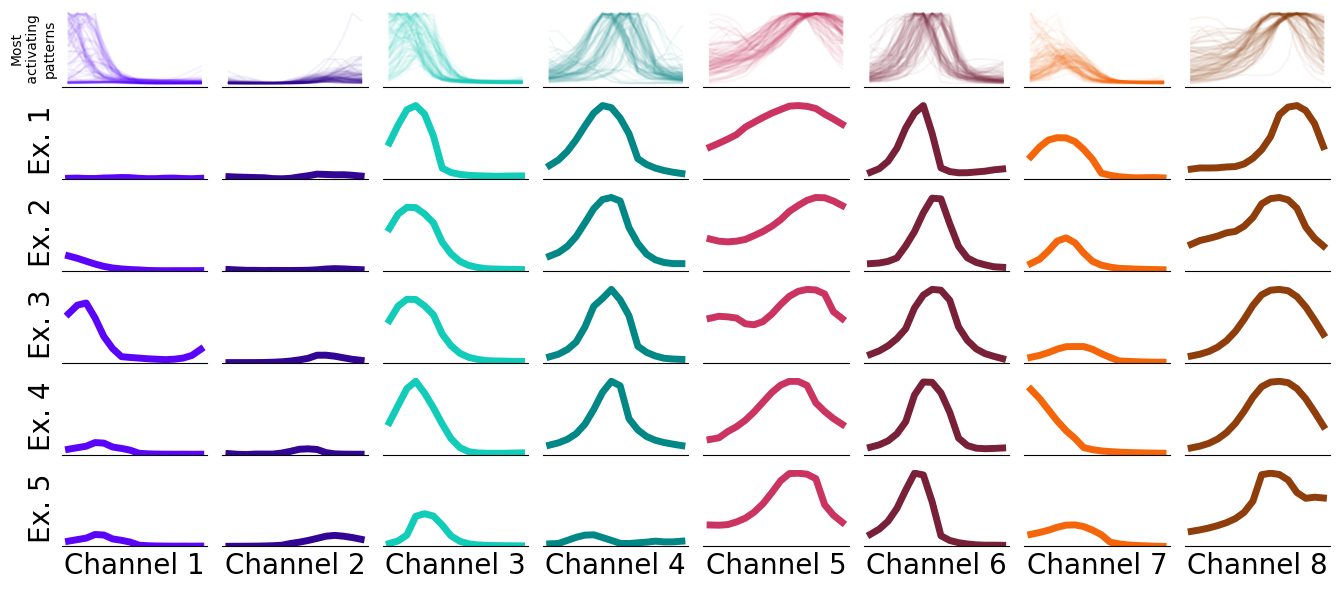

In [13]:
colors = ['#5a05fa', '#320594', '#11ccb9', '#018786', '#cb3461', '#792039', '#f5660a', '#8e3d0b',]
np.random.seed(0)
num_samples=5
cmap = mpl.cm.get_cmap('Dark2')


fig, axes = plt.subplots(ncols = num_channels, 
                         nrows = num_samples+1, 
                         figsize = ((num_channels+1)*1.5, 
                                    (num_samples+1)))

for i in range(num_channels):
    axes[0,i].plot(test_out[i].T, c= colors[i], alpha = .05)
    axes[0,0].set_ylabel("Most\n activating \npatterns", fontsize = 10, rotation = 90)
    axes[-1,i].set_xlabel("Channel {}".format(i+1), fontsize = 20)
#     axes[0,i].set_xlabel("Channel # {}".format(i), )
#     axes[-2,i].xaxis.labelpad = 50
    my_idxs =-np.random.choice(num_samples_all,size=num_samples)

    axes[0,i].set_yticks([]);
    axes[0,i].set_xticks([]);        
    axes[0,i].spines.right.set_visible(False)
    axes[0,i].spines.top.set_visible(False)
        
    axes[0,i].spines.left.set_visible(False)
    for j in range(1,num_samples+1):
        axes[j,0].set_ylabel("Ex. {}".format(j), fontsize = 20,)

#         axes[j,0].set_ylabel("Ex. # {}".format(j-1))

        axes[j,i].plot(test_out[i,my_idxs[j-1]], 
                       linewidth =5,  
                       c=  colors[i])
        axes[j,i].set_yticks([]);
        axes[j,0].set_yticks([]);
        axes[j,i].spines.right.set_visible(False)
        axes[j,i].spines.top.set_visible(False)
        
        axes[j,i].spines.left.set_visible(False)
   
        

        axes[j,i].set_xticks([]);
        axes[j,i].set_ylim([0,1.05], );

    
axes[0,0].set_yticks([]);

plt.tight_layout()
# plt.savefig(oj(fig_path, "features.pdf"))       


# zoomed in feature

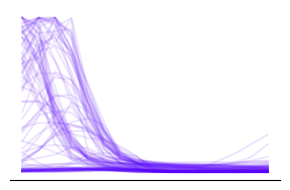

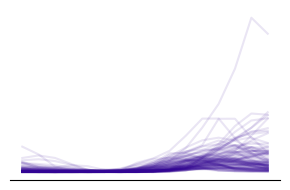

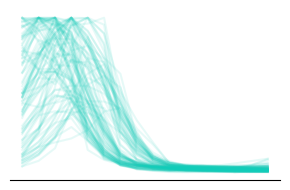

In [14]:




# gs1 = gridspec.GridSpec(4, 4)
# gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 
channel_list = [0,1,2]
for i in channel_list:
    fig, axes = plt.subplots(ncols = 1, 
                         nrows = 1, 
                         figsize = (3,2))
    axes.plot(test_out[i].T, c= colors[i], alpha = .1)

#     maxpos_vect = np.column_stack(np.unravel_index(max_idx, ( num_dataset, 209)))
    axes.set_yticks([]);
    axes.set_xticks([]);        
    axes.spines.right.set_visible(False)
    axes.spines.top.set_visible(False)
        
    axes.spines.left.set_visible(False)

        

#         axes[j,i].set_xticks([]);
    axes.set_yticks([]);
#         axes[j,i].set_ylim([0,1.05], );
    plt.tight_layout()
    plt.savefig(oj(fig_path, "feature_zoom_{}.svg".format(i)))   

    



# new grad

In [15]:
b = np.asarray([500*x for x in range(1,9)])
b[0] = 400
b[2] = 1650
b[-3] = 3100
a = ((b-400)/17.2).astype(np.int32)
# plt.xticks(ticks = a,labels = b, fontsize = 20);

In [16]:
irindex.columns[8:]

Index(['alkane', 'methyl', 'alkene', 'alkyne', 'alcohols', 'amines',
       'nitriles', 'aromatics', 'alkyl halides', 'esters', 'ketones',
       'aldehydes', 'carboxylic acids', 'ether', 'acyl halides', 'amides',
       'nitro'],
      dtype='object')

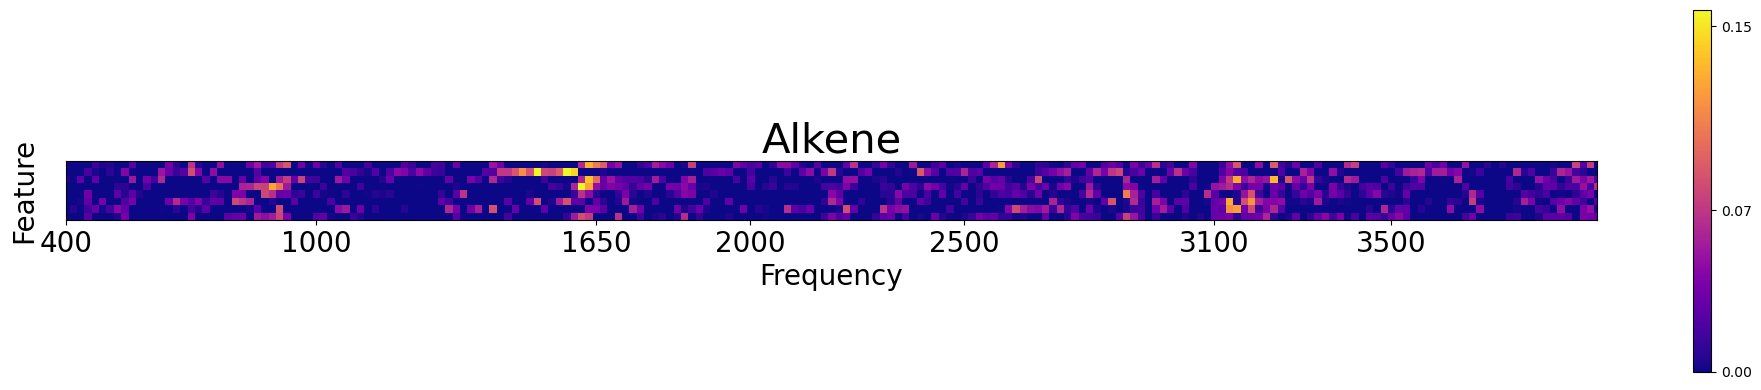

In [17]:
W = model.classifier[0].weight.detach().cpu().numpy()
W = W.reshape((17, 8, -1))
# highest_val = np.percentile(W, 99.9)
lowest_val = 0
# for functional_group in range(17):
functional_group = 2

W_fun = W[functional_group]
W_fun = np.maximum(0, W_fun)
highest_val = np.percentile(W_fun, 99.9)
fig, ax = plt.subplots(figsize = (20,4))



plt.imshow(W_fun, vmin = lowest_val, vmax = highest_val, cmap =plt.get_cmap('plasma'))

plt.xticks(ticks = a,labels = b, fontsize = 20);
plt.yticks([]);
ax.set_xlim(0,208)
ax.set_xlabel("Frequency", fontsize =20,)

ax.set_ylabel("Feature", fontsize =20,rotation = 90, labelpad=20)
plt.title((irindex.columns[8+functional_group]).capitalize(), fontsize = 30);
plt.colorbar(ticks = [0, 0.07,.15])
plt.tight_layout()
plt.savefig(oj(fig_path, "acts_{}_color_scale.pdf".format(irindex.columns[8+functional_group])),bbox_inches='tight')
# break

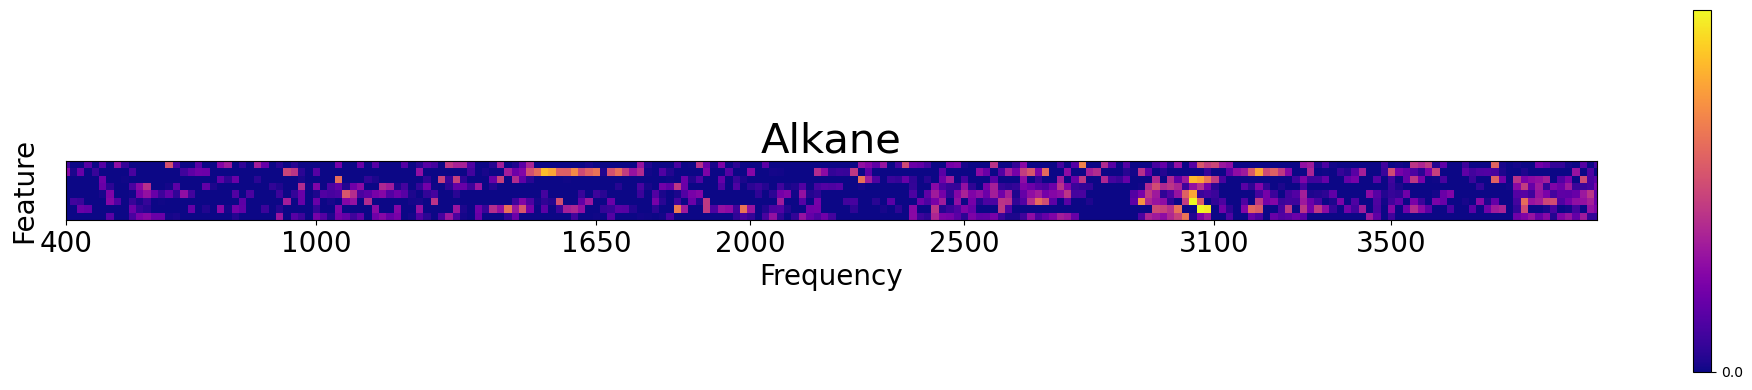

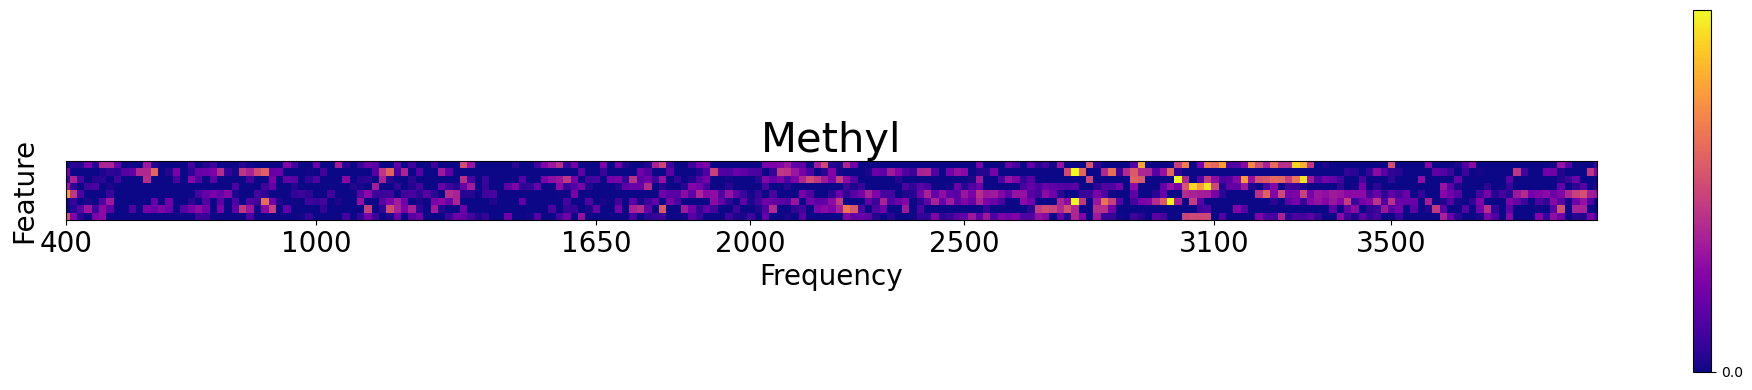

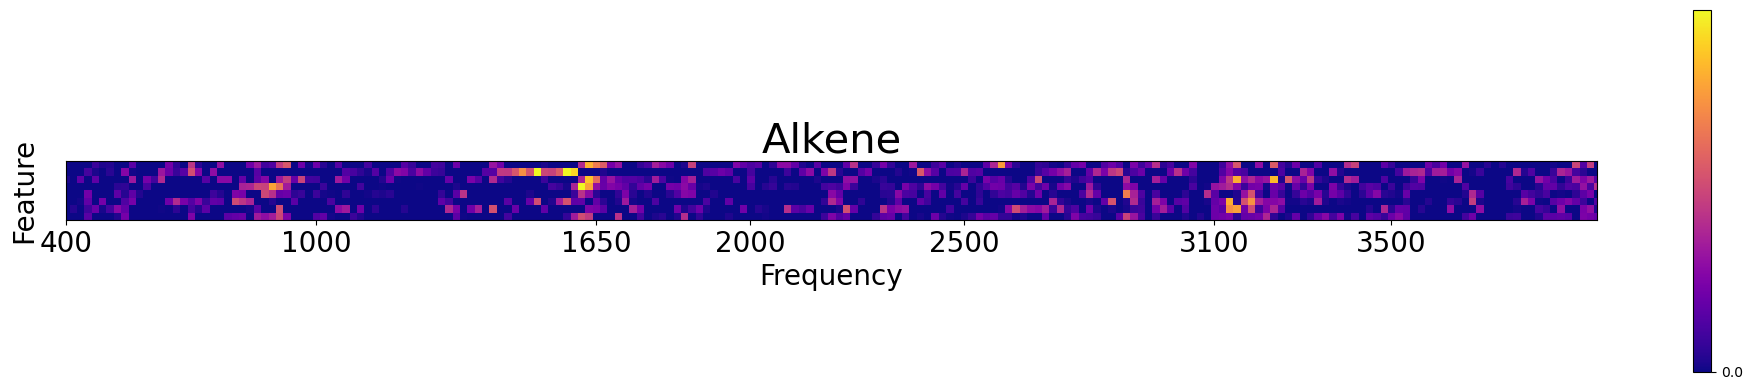

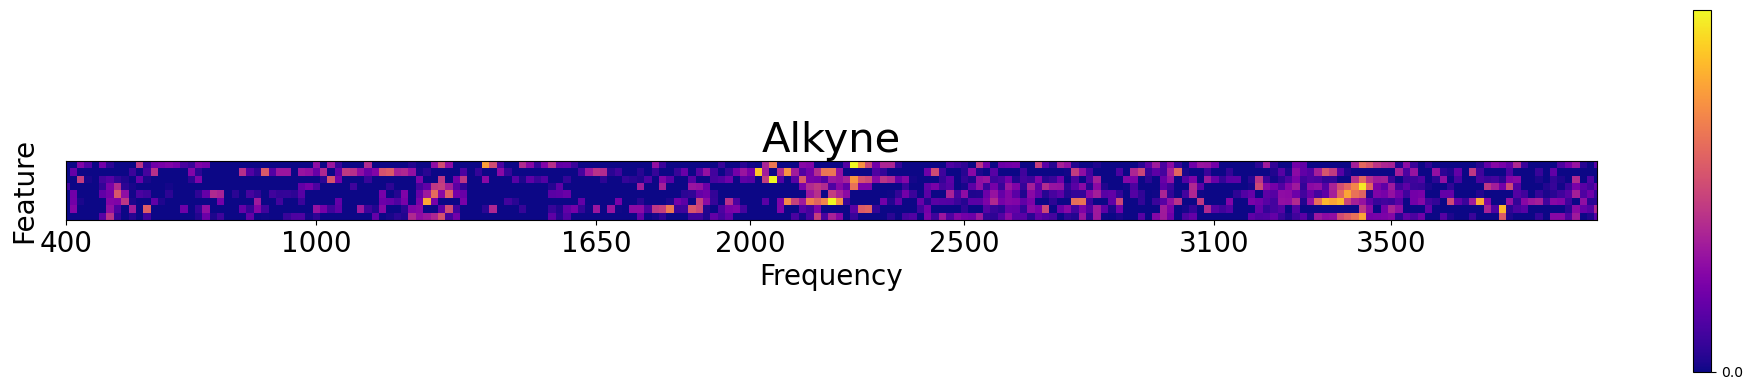

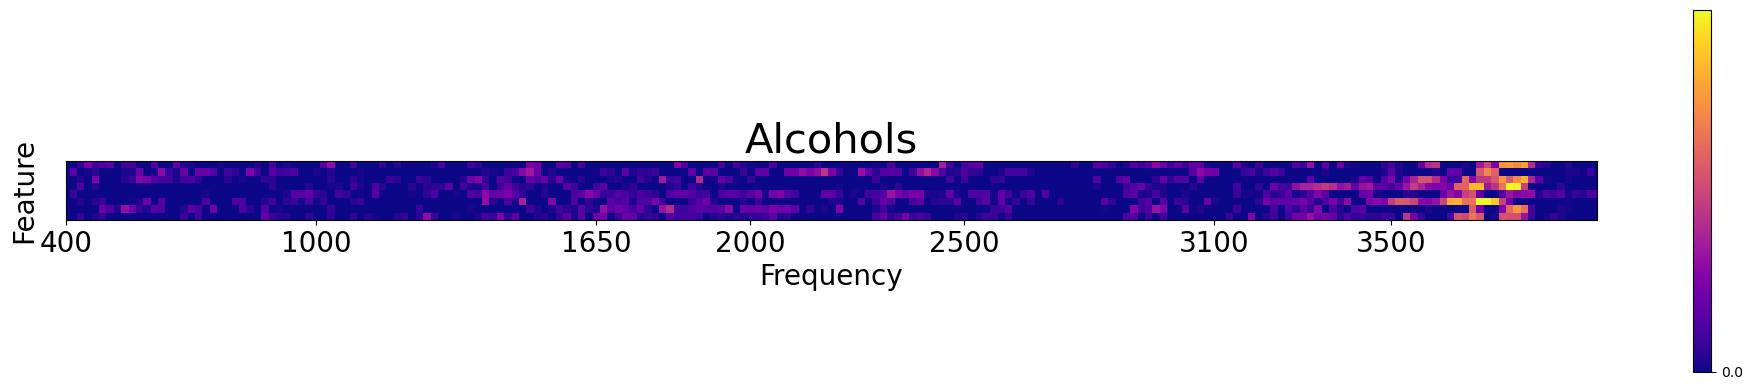

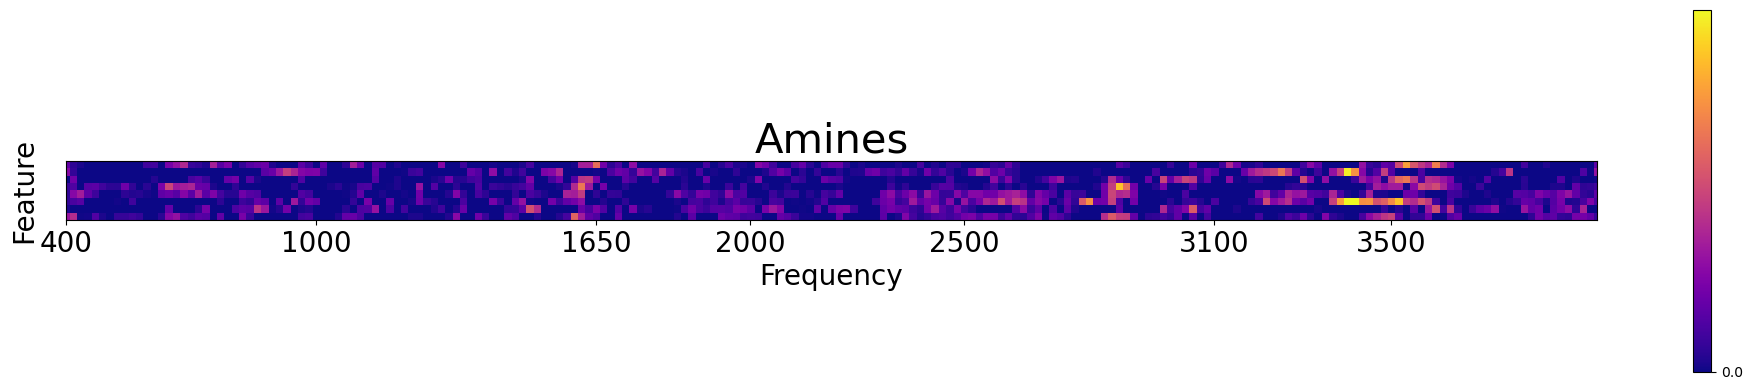

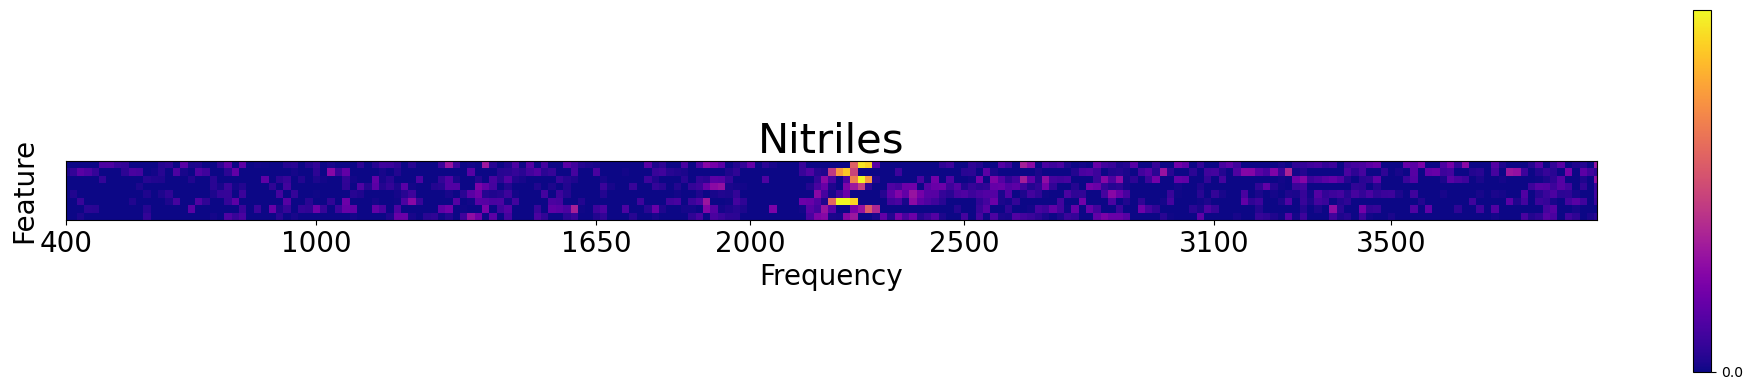

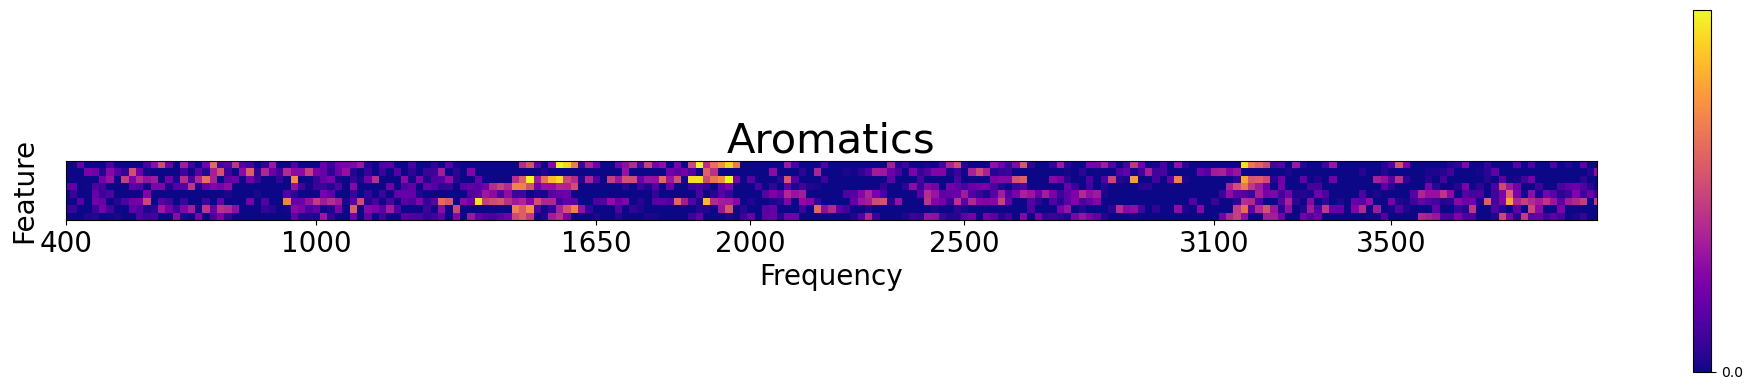

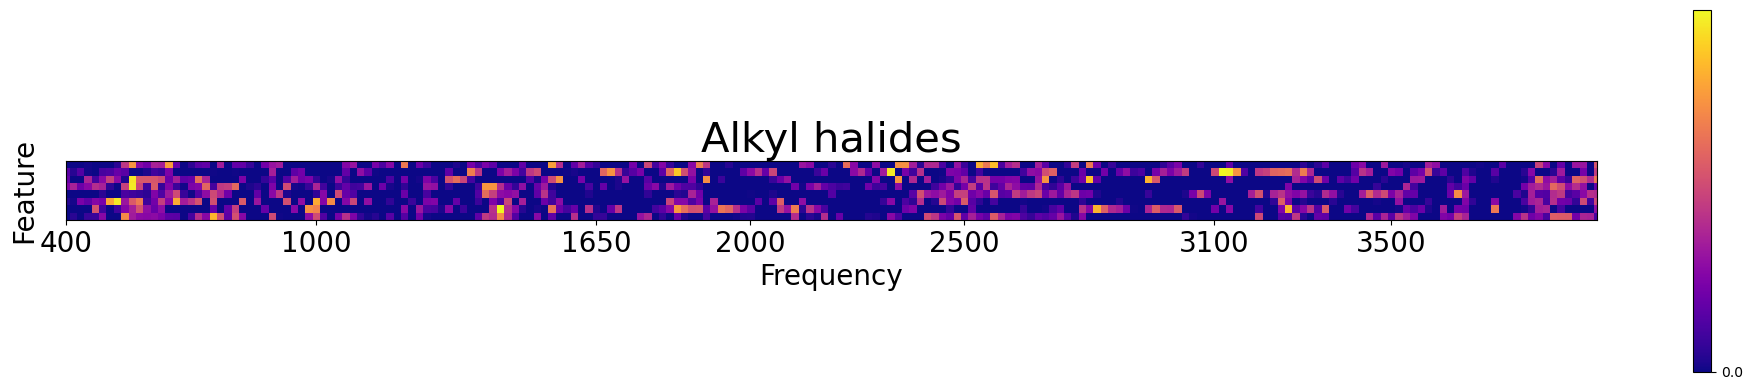

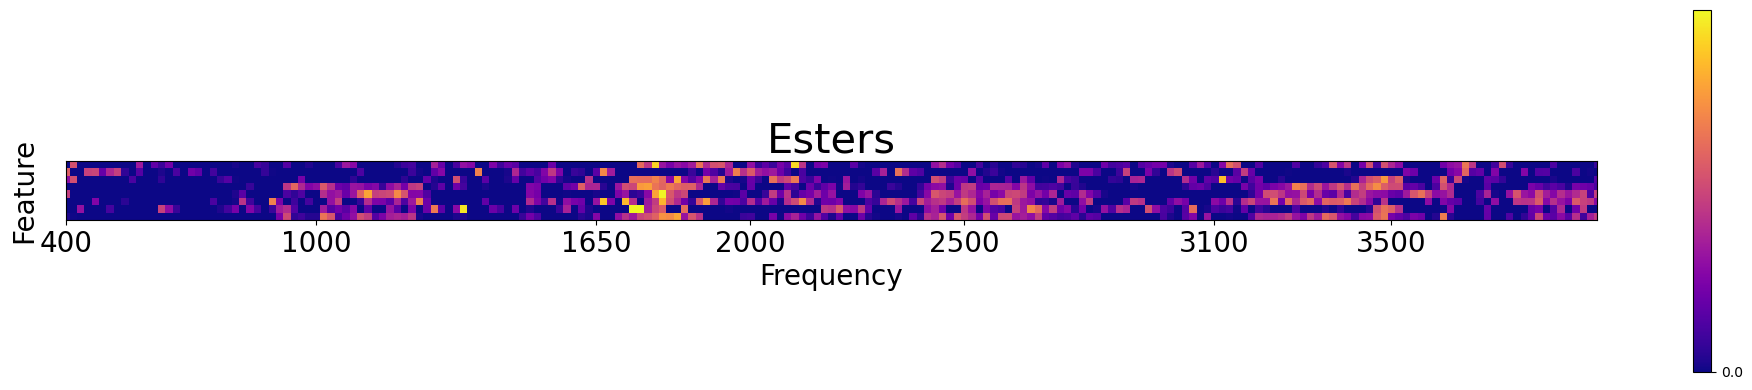

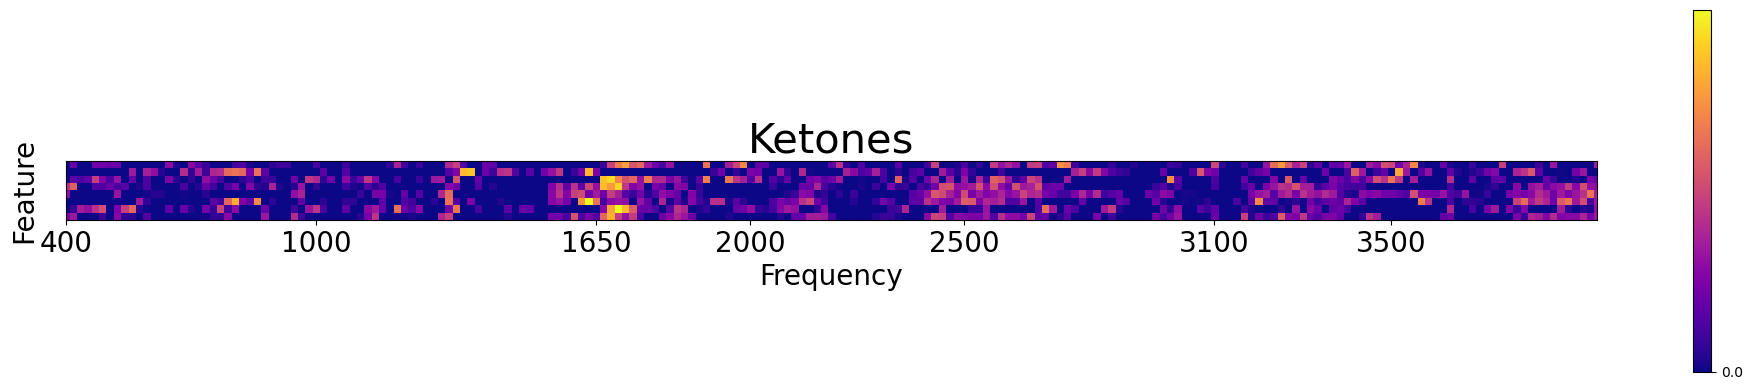

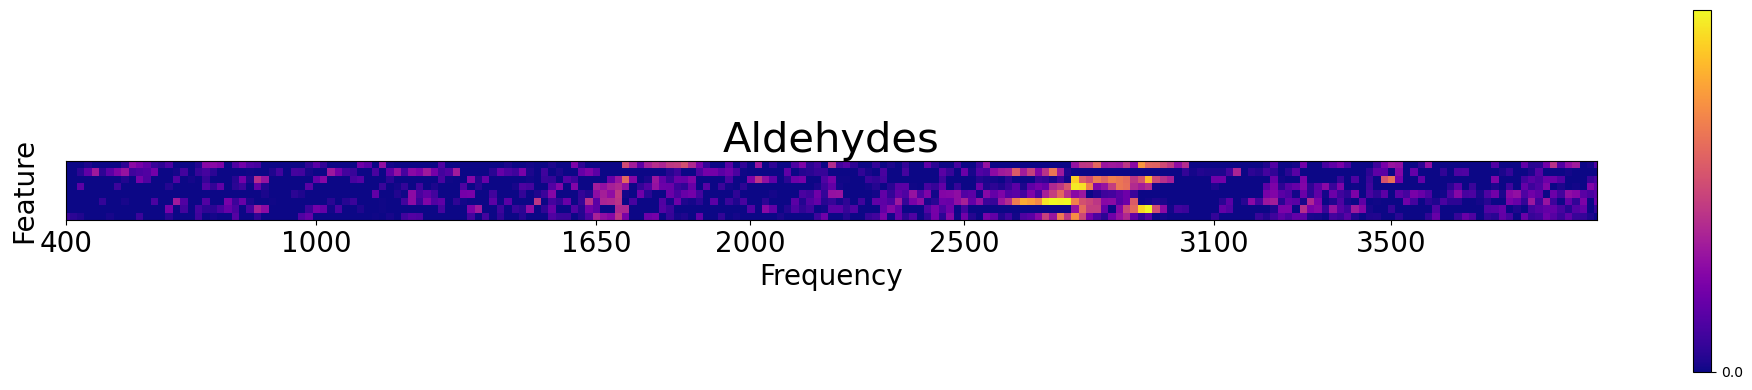

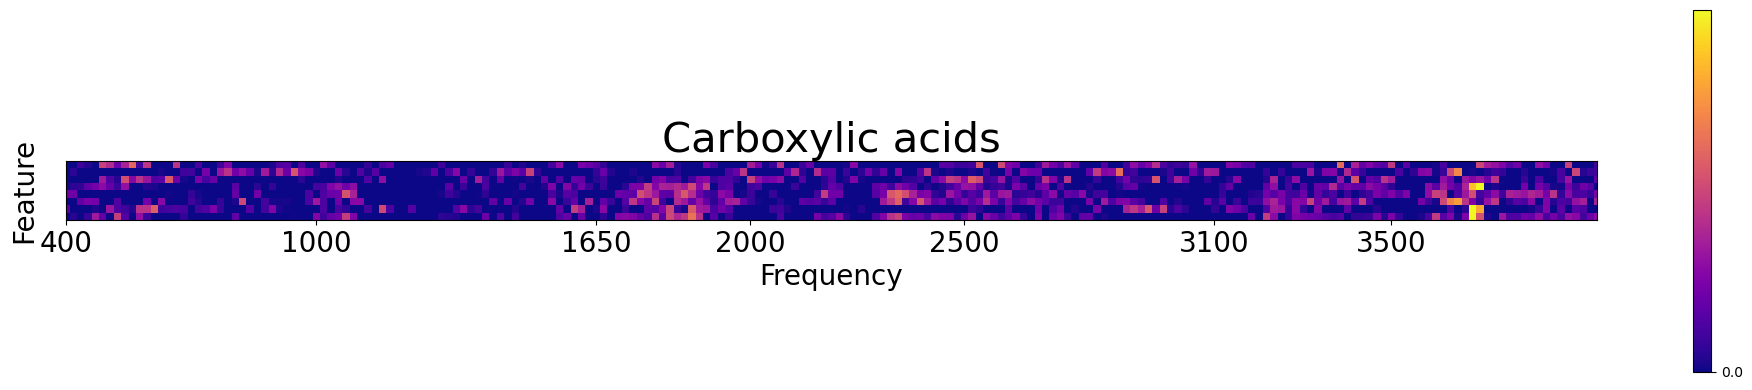

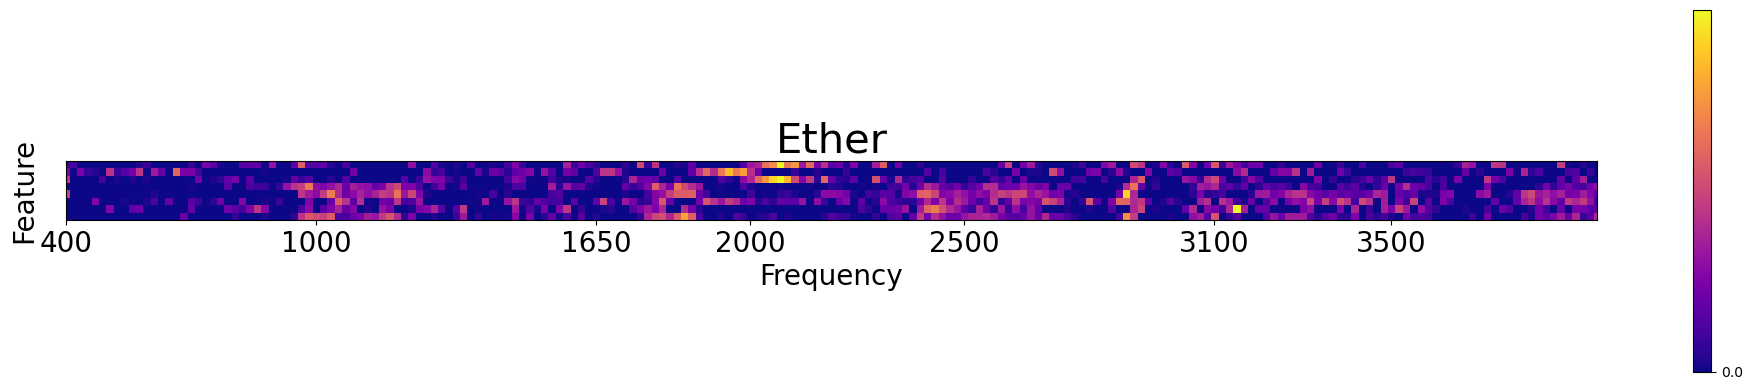

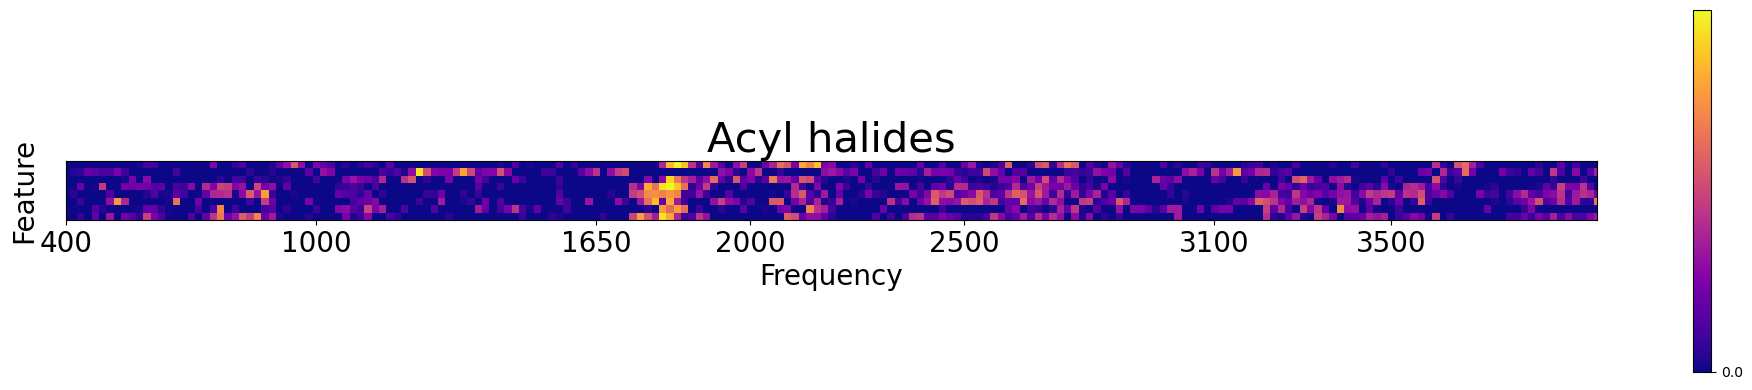

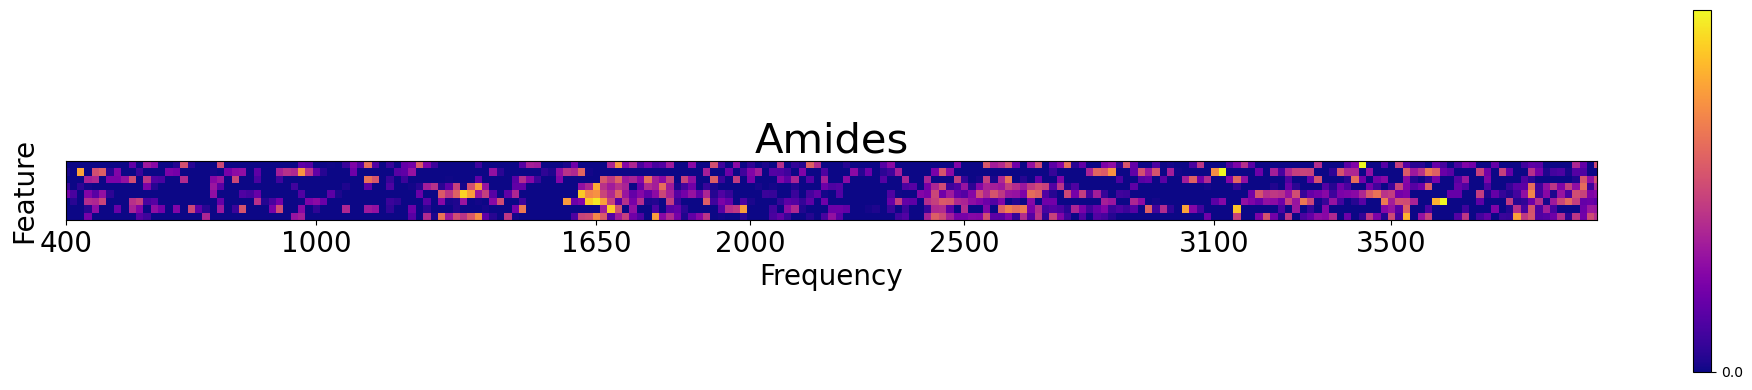

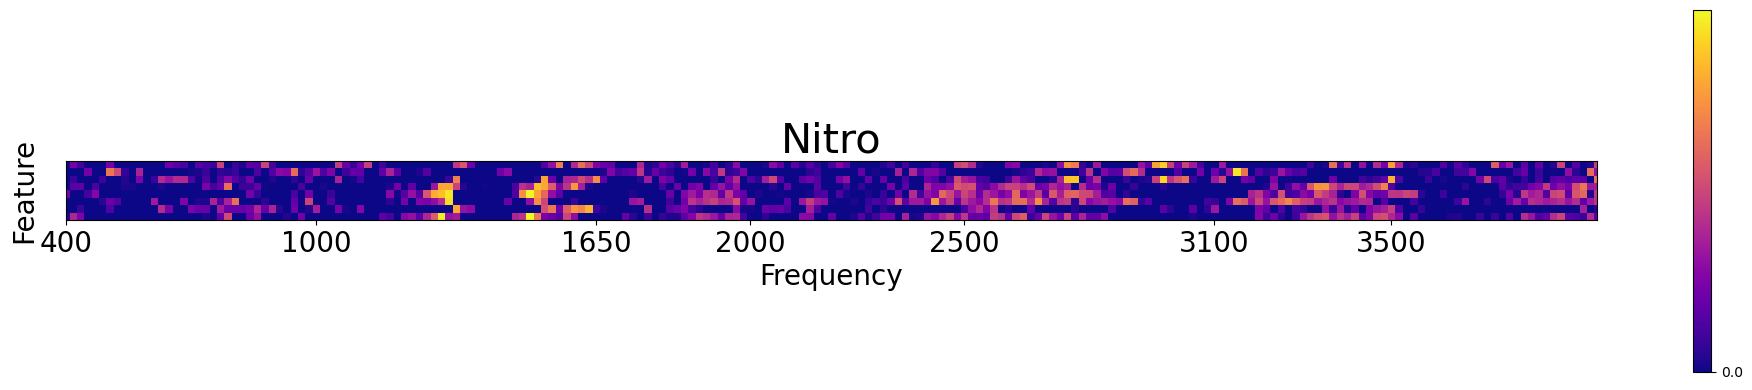

In [18]:
W = model.classifier[0].weight.detach().cpu().numpy()
W = W.reshape((17, 8, -1))
# highest_val = np.percentile(W, 99.9)
lowest_val = 0
for functional_group in range(17):
    W_fun = W[functional_group]
    W_fun = np.maximum(0, W_fun)
    highest_val = np.percentile(W_fun, 99.9)
    fig, ax = plt.subplots(figsize = (20,4))
    plt.imshow(W_fun, vmin = lowest_val, vmax = highest_val, cmap =plt.get_cmap('plasma'))
    plt.xticks(ticks = a,labels = b, fontsize = 20);
    plt.yticks([]);
    ax.set_xlim(0,208)
    ax.set_xlabel("Frequency", fontsize =20,)
    ax.set_ylabel("Feature", fontsize =20,rotation = 90, labelpad=20)
    plt.title((irindex.columns[8+functional_group]).capitalize(), fontsize = 30);
    plt.colorbar(ticks = [0, np.ceil(highest_val*10+1)/5,np.ceil(highest_val*10+1)/10])
    plt.tight_layout()
    plt.savefig(oj(fig_path, "acts_{}.pdf".format(irindex.columns[8+functional_group])),bbox_inches='tight')
    # break

In [19]:
#pickle weights
pkl_dict ={}
for functional_group in range(17):


    W = model.classifier[0].weight.detach().cpu().numpy()
    W = W.reshape((17, 8, -1))
    W_fun = W[functional_group]
    pkl_dict[irindex.columns[8+functional_group]] = W_fun
# save the dictionary
with open(oj(fig_path, 'weights.pkl'), 'wb') as f:
    pickle.dump(pkl_dict, f, pickle.HIGHEST_PROTOCOL)

In [20]:
for functional_group in range(17):
    print("\\begin{{figure*}} \centering \includegraphics[width=.95\linewidth]{{Figures/acts_{0}.pdf}}  \caption{{Dense weights for {0}}} \end{{figure*}}".format(irindex.columns[8+functional_group]))



\begin{figure*} \centering \includegraphics[width=.95\linewidth]{Figures/acts_alkane.pdf}  \caption{Dense weights for alkane} \end{figure*}
\begin{figure*} \centering \includegraphics[width=.95\linewidth]{Figures/acts_methyl.pdf}  \caption{Dense weights for methyl} \end{figure*}
\begin{figure*} \centering \includegraphics[width=.95\linewidth]{Figures/acts_alkene.pdf}  \caption{Dense weights for alkene} \end{figure*}
\begin{figure*} \centering \includegraphics[width=.95\linewidth]{Figures/acts_alkyne.pdf}  \caption{Dense weights for alkyne} \end{figure*}
\begin{figure*} \centering \includegraphics[width=.95\linewidth]{Figures/acts_alcohols.pdf}  \caption{Dense weights for alcohols} \end{figure*}
\begin{figure*} \centering \includegraphics[width=.95\linewidth]{Figures/acts_amines.pdf}  \caption{Dense weights for amines} \end{figure*}
\begin{figure*} \centering \includegraphics[width=.95\linewidth]{Figures/acts_nitriles.pdf}  \caption{Dense weights for nitriles} \end{figure*}
\begin{figur

# Figures


In [22]:
# comparison plot
name_list = [x.capitalize() for x in irindex.columns[8:]]

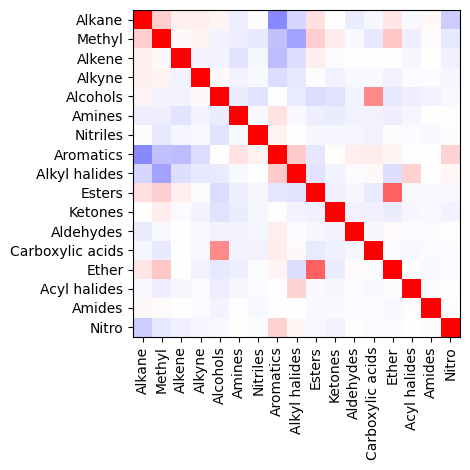

In [23]:

plt.imshow(np.corrcoef (y.T), cmap = plt.get_cmap('bwr'), vmax =1, vmin =-1)
plt.yticks(np.arange(17), name_list);
plt.xticks(np.arange(17), name_list,rotation =90);
# plt.xticks([]);
plt.tight_layout()

plt.savefig(oj(fig_path, "correlation.pdf"),bbox_inches='tight')
